## Required imports

In [16]:
%matplotlib notebook

import os, time
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import scipy.signal

import pyabf # see: https://github.com/swharden/pyABF

# need this to update matplotlib plots in jupyter notebook
plt.ion()

# These two lines will auto reload imports, in particular bAnalysis
%load_ext autoreload
%autoreload 2

from bAnalysis import bAnalysis

ba = None # global bAnalysis object, used throughout this notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Manually load an .abf file using bAnalysis 

In [17]:
file = 'data/19114001.abf'
ba = bAnalysis.bAnalysis(file)

# ba is an object of type bAnalysis, see bAnalysis.py for its data members and member functions 

# print some info about it
print(ba)

# get the sweep list
print('ba.sweepList:', ba.sweepList)

# set the sweep (there will be no output)
ba.setSweep(0)

# set a sweep that does not exist
#ba.setSweep(10)

# get dataPointsPerMs
print('ba.dataPointsPerMs:', ba.dataPointsPerMs)

file: data/19114001.abf
ABF (version 2.0.0.0) with 1 channel (mV), sampled at 20.0 kHz, containing 1 sweep, having no tags, with a total length of 1.00 minutes, recorded with protocol "C:\Users\Lab\Documents\Molecular Devices\pCLAMP\Params\claudia\Gapfree AP".
ba.sweepList: [0]
ba.dataPointsPerMs: 20


## Load an abf file

<IPython.core.display.Javascript object>


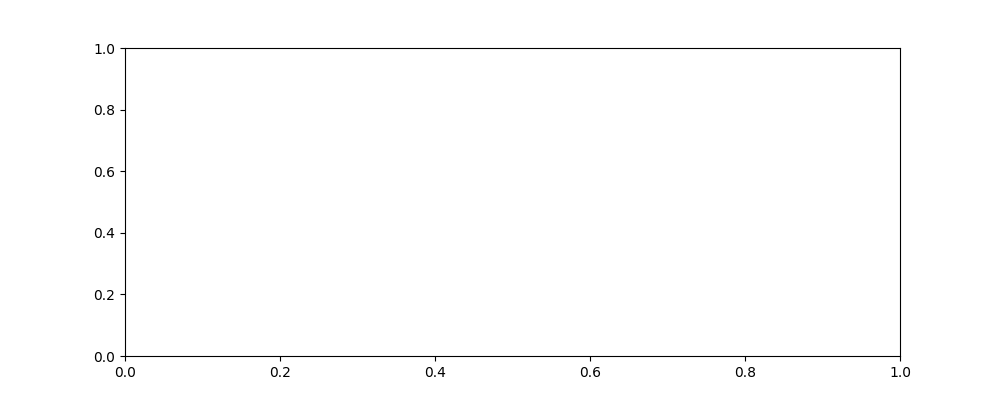

In [19]:
#from IPython.display import clear_output

path = 'data'
files = os.listdir(path)

def fileList_callback(b):
    newValue = b['new']
    file = os.path.join('data', newValue)
    global ba
    ba = bAnalysis.bAnalysis(file)
    
    #clear_output()
    myAxis.clear()
    ba.plotSpikes(ax=myAxis)
    global sweeps
    sweepList.options = ba.sweepList
    
fileList = widgets.Select(
    options=files,
    # rows=10,
    description='fileList',
    disabled=False
)

def sweepList_callback(b):
    newValue = b['new']
    global ba
    ba.setSweep(newValue)
    #clear_output()
    myAxis.clear()
    ba.plotSpikes(ax=myAxis)

sweeps = []
sweepList = widgets.Select(
    options=sweeps,
    # rows=10,
    description='sweeps',
    disabled=False
)

def loadButton_callback(b):
    file = os.path.join('data', fileList.value)
    
    global ba
    ba = bAnalysis.bAnalysis(file)
    
    #clear_output()
    myAxis.clear()
    ba.plotSpikes(ax=myAxis)
    global sweeps
    sweepList.options = ba.sweepList
    
loadButton = widgets.Button(
    description='Load',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Load selected file'
)

loadButton.on_click(loadButton_callback)
sweepList.observe(sweepList_callback, names='value')
fileList.observe(fileList_callback, names='value')

fig = plt.figure(figsize=(10, 4))
myAxis = fig.add_subplot(1, 1 , 1)

HBox(children=[fileList, sweepList, loadButton])




## Check the derivative of Vm (dV/dt) to select threshold for spike detection.

<IPython.core.display.Javascript object>


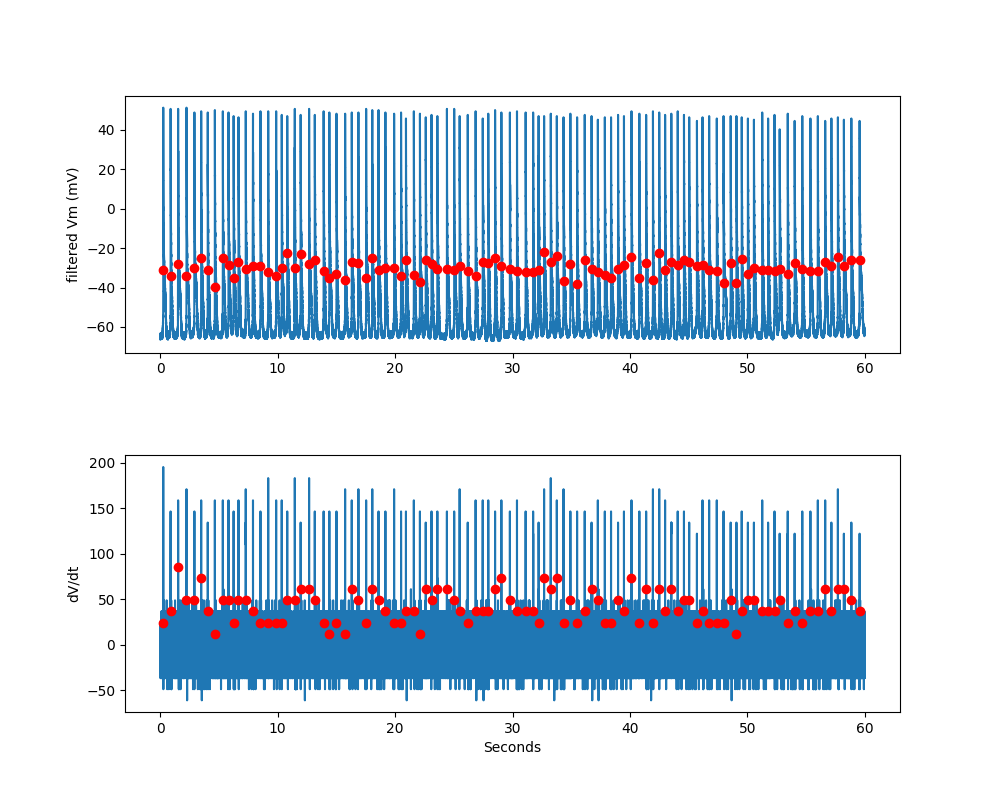

detected 103 spikes medianFilter: 3 dVthresholdPos: 100


<IPython.core.display.Javascript object>


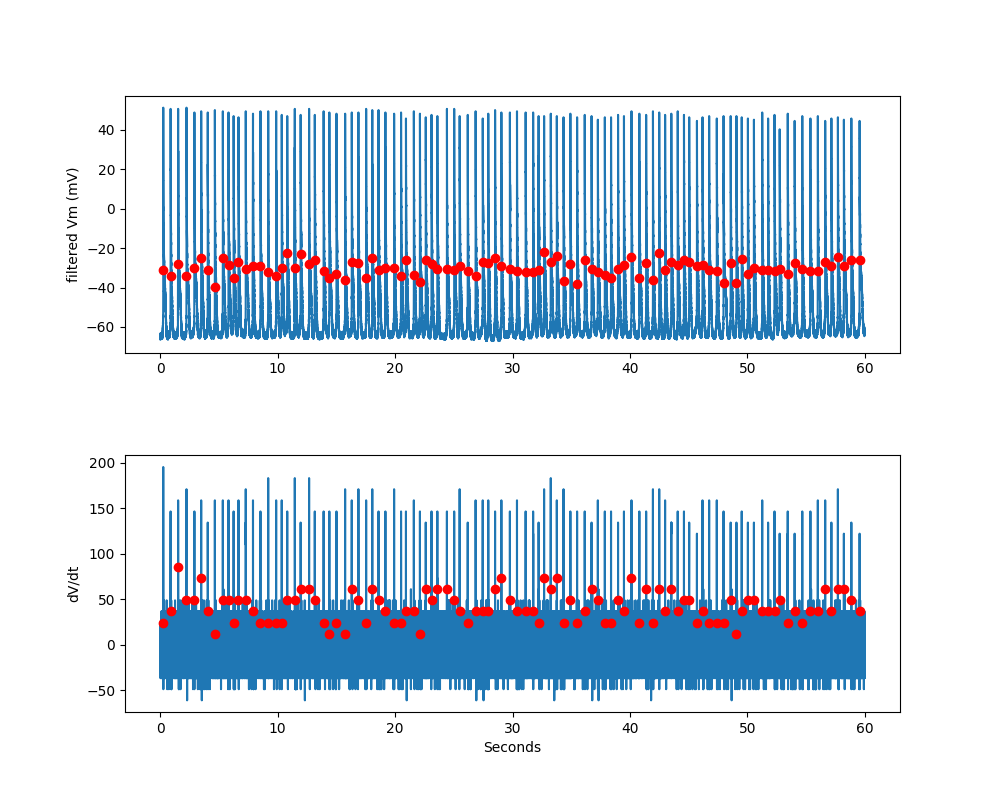

In [20]:
ba.plotDeriv(medianFilter=3, dVthresholdPos=100)

## Run spike detection with myThreshold and plot results

bAnalysis.spikeDetect() for file data/19114001.abf detected 103 spikes in 0.06 seconds


<IPython.core.display.Javascript object>


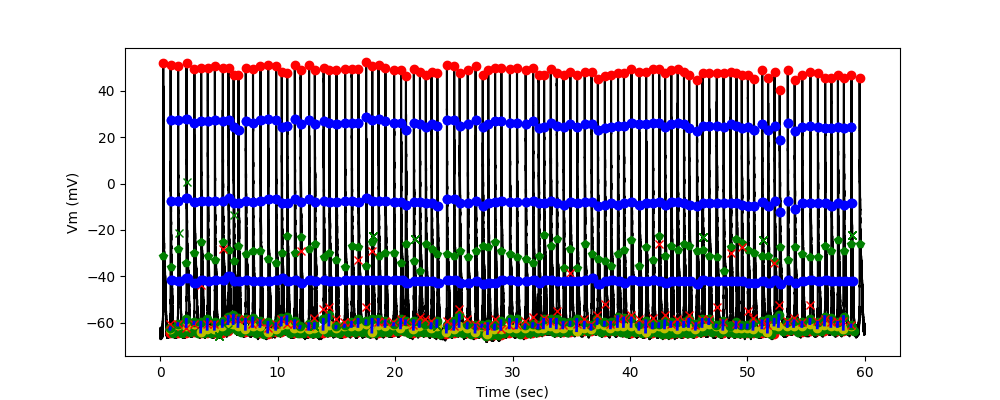

In [21]:
# load a file
#file = 'data/19114001.abf'
#ba = bAnalysis.bAnalysis(file)

# spike detect
myThreshold = 100
halfHeights = [20, 50, 80]
ba.spikeDetect(dVthresholdPos=myThreshold, halfHeights=halfHeights)

#
# plot Vm with all detected spikes (threshold, peak, pre/post min, half-wdiths
fig = plt.figure(figsize=(10, 4))
myAxis = fig.add_subplot(1, 1 , 1)

ba.plotSpikes(ax=myAxis)



## Make a spike browser

<IPython.core.display.Javascript object>


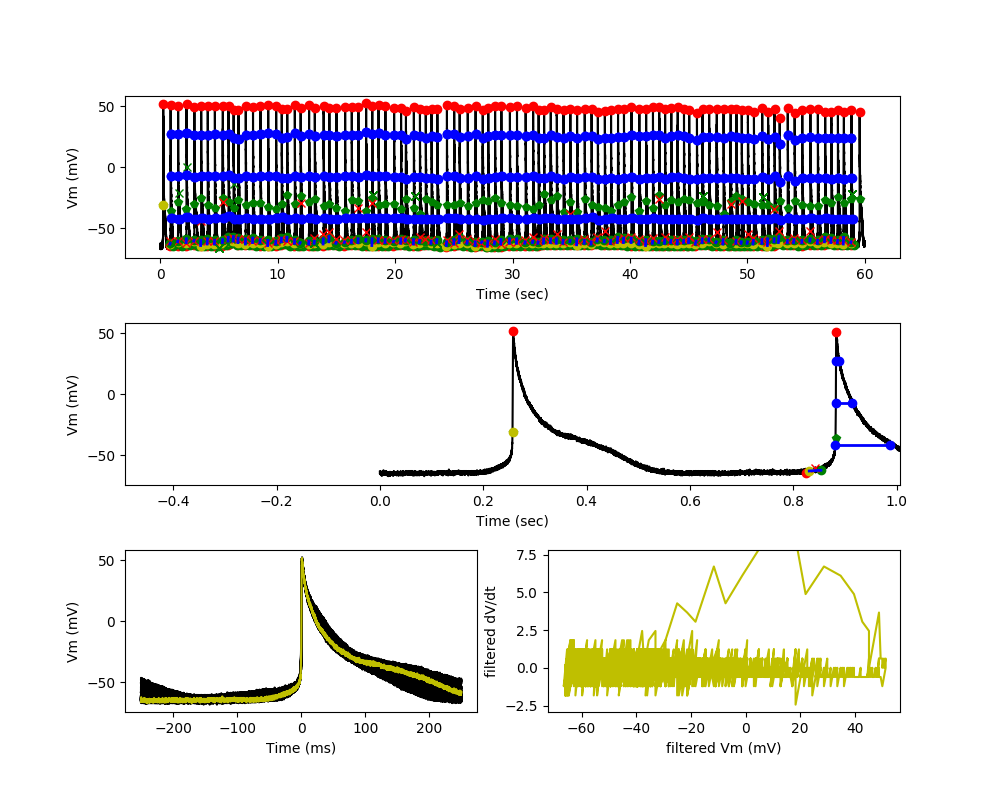

In [23]:
currentSpikeNumber = 1

#
# make a figure with subplots and plot it once
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.4)

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep
ax2 = fig.add_subplot(grid[1, 0:]) #Vm, middle zoom
ax3 = fig.add_subplot(grid[2, 0]) #Vm, spike clip
ax4 = fig.add_subplot(grid[2, 1]) #phase plot

#
# plot vm
line1 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax1)

#
# plot middle view with intermediate x-axis
line2 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax2)

#
# plot all clips
line3 = ba.plotClips(oneSpikeNumber=currentSpikeNumber, ax=ax3)

#
# plot one spike phase plot
line4 = ba.plotPhasePlot(oneSpikeNumber=currentSpikeNumber, ax=ax4)

fig.show()
fig.canvas.draw()

def updatePlot(spikeNumber):
    ''' When called as an ipywidget callback, spikeNumber is a dicitonary !!!'''
    if isinstance(spikeNumber, dict):
        spikeNumber = spikeNumber['new']
    
    global currentSpikeNumber
    currentSpikeNumber = spikeNumber
    
    #
    # plot one spike (red circle)
    line1.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line1.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])

    #
    # plot one spike clip
    if line3 is not None:
        line3.set_ydata(ba.spikeClips[spikeNumber])

    #
    # intermediate (x-axis) plot
    minTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] - 0.75
    maxTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] + 0.75
    ax2.axes.set_xlim(minTime, maxTime)
    line2.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line2.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])
    
    #
    # phase plot
    filteredClip = scipy.signal.medfilt(ba.spikeClips[spikeNumber],3)
    dvdt = np.diff(filteredClip)
    # add an initial point so it is the same length as raw data in abf.sweepY
    dvdt = np.concatenate(([0],dvdt))
    
    line4.set_xdata(filteredClip)
    line4.set_ydata(dvdt)
    
    # trying to rescale the axis on each update, not working
    #ax4.autoscale_view()
    ax4.relim()
    
    fig.canvas.draw()
    
mySlider = widgets.IntSlider(
    min=0,
    max=ba.numSpikes-1,
    step=1,
    description='Spike Number',
    value=0,
    continuous_update=False)
mySlider.observe(updatePlot, names='value')

def on_slider_change(change):
    updatePlot(change['new'])
    
def myButton_prev_callback(b):
    global currentSpikeNumber
    currentSpikeNumber -= 1
    if currentSpikeNumber < 0:
        currentSpikeNumber = 0
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_prev = widgets.Button(
    description='Previous Spike',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to previous spike'
)
myButton_prev.on_click(myButton_prev_callback)


def myButton_next_callback(b):
    global currentSpikeNumber
    currentSpikeNumber += 1
    if currentSpikeNumber > ba.numSpikes - 1:
        currentSpikeNumber = ba.numSpikes - 1
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_next = widgets.Button(
    description='Next Spike',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to next spike'
)
myButton_next.on_click(myButton_next_callback)


# initial plot
updatePlot(spikeNumber=0)

# display the controls horizontally
HBox(children=[mySlider, myButton_prev, myButton_next])

## Additional analysis

<IPython.core.display.Javascript object>


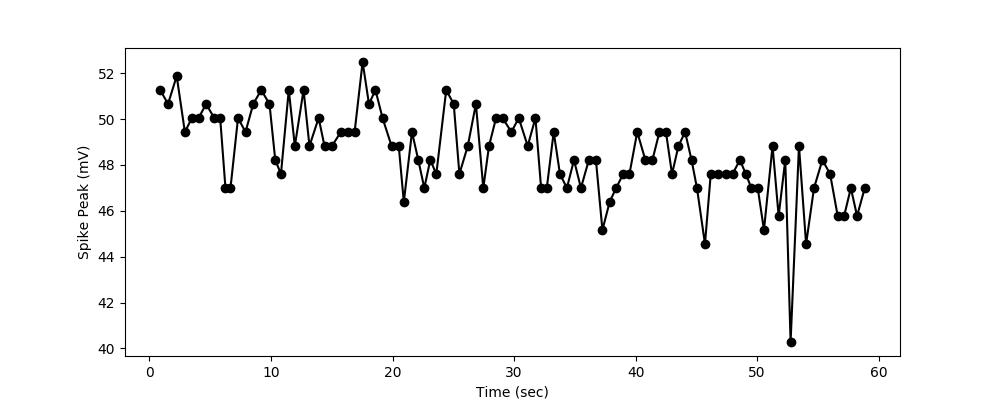

<IPython.core.display.Javascript object>


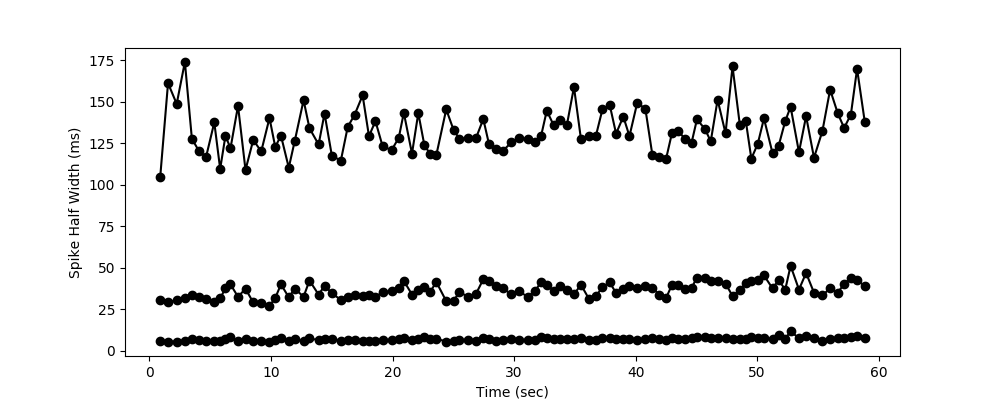

<IPython.core.display.Javascript object>


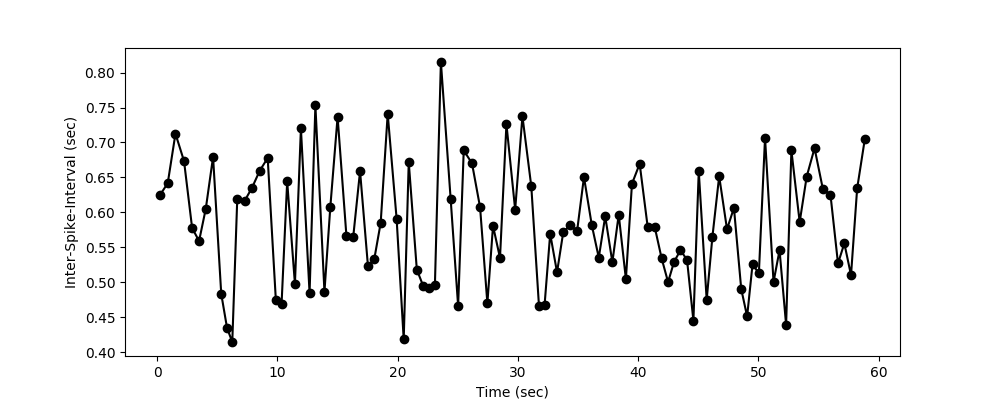

<IPython.core.display.Javascript object>


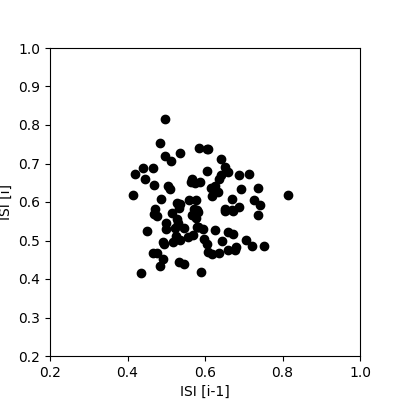

,file,spikeNumber,thresholdSec,peakSec,preMinVal,postMinVal,widths
1,data/19114001.abf,1,0.88205,0.88330,-64.520264,-64.410400,"[{'risingPnt': 17633, 'risingVal': -39.67285, ..."
2,data/19114001.abf,2,1.52385,1.52505,-64.410400,-64.599609,"[{'risingPnt': 30462, 'risingVal': -41.503906,..."
3,data/19114001.abf,3,2.23640,2.23805,-64.599609,-63.830566,"[{'risingPnt': 44721, 'risingVal': -39.67285, ..."
4,data/19114001.abf,4,2.90975,2.91095,-63.830566,-64.501953,"[{'risingPnt': 58181, 'risingVal': -42.114258,..."
5,data/19114001.abf,5,3.48735,3.48835,-64.501953,-64.294434,"[{'risingPnt': 69731, 'risingVal': -40.893555,..."
6,data/19114001.abf,6,4.04635,4.04780,-64.294434,-64.581299,"[{'risingPnt': 80914, 'risingVal': -40.893555,..."
7,data/19114001.abf,7,4.65155,4.65285,-64.581299,-64.373779,"[{'risingPnt': 93020, 'risingVal': -40.893555,..."
8,data/19114001.abf,8,5.33080,5.33170,-64.373779,-63.800049,"[{'risingPnt': 106602, 'risingVal': -40.283203..."
9,data/19114001.abf,9,5.81425,5.81540,-63.800049,-62.011719,"[{'risingPnt': 116274, 'risingVal': -39.0625, ..."


In [24]:
#
# plot the value of each spike amplitude over time of recording
# if this is changing during the recording then there might be problems
fig = plt.figure(figsize=(10, 4))
myAxis2 = fig.add_subplot(1, 1 , 1)

ba.plotTimeSeries(stat='peak', ax=myAxis2)
    
#
# plot the value of each half-width for each spike over time of recording
fig = plt.figure(figsize=(10, 4))
myAxis3 = fig.add_subplot(1, 1 , 1)

for i, halfHeight in enumerate(halfHeights):
    ba.plotTimeSeries(stat='halfWidth', halfWidthIdx=i, ax=myAxis3)
    
#
# plot ISI between each spike
fig = plt.figure(figsize=(10, 4))
myAxis4 = fig.add_subplot(1, 1 , 1)

ba.plotISI(ax=myAxis4)

#
# plot isi[i] versus isi[i-1], e.g. a 'shot plot'
# this will show us if there is history between successive intervals
# if it is a circular cloud, then there is little/no history between successive ISI's
spikeTimes_sec = [x/ba.abf.dataPointsPerMs/1000 for x in ba.spikeTimes]
isi = np.diff(spikeTimes_sec)
isi_i = isi[1:len(isi)-1]
isi_i_minus_1 = isi[0:len(isi)-2]

grid = plt.GridSpec(1, 1, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep
ax.plot(isi_i_minus_1, isi_i, 'ok')
ax.axes.set_xlim(0.2, 1)
ax.axes.set_ylim(0.2, 1)
ax.set_ylabel('ISI [i]')
ax.set_xlabel('ISI [i-1]')

#
# make a report of all spike times
from IPython.display import display, HTML
df = ba.report()
# for now, just showing first 10 spikes
display(df[1:10])
# not sure what this does but might be important
#display(HTML(df.to_html()))


## Statistics

In [27]:
from scipy import stats

#
# compare spike peaks at the start and end of the recording

# build a list of spike peaks
spikePeaks = [spike['peakVal'] for spike in ba.spikeDict]

# first 10 spikes peaks
first = spikePeaks[0:10]
mean1 = np.mean(first)
std1 = np.std(first)

# last 10 spikes peaks
last = spikePeaks[len(spikePeaks)-10:len(spikePeaks)-1]
mean2 = np.mean(last)
std2 = np.std(last)

p = stats.ttest_ind(first,last)

if p[1] < 0.05:
    print('p=', p[1], ' is SIGNIFICANT')
else:
    print('p=', p[1], ' is NOT SIGNIFICANT')


p= 7.227717009995907e-08  is SIGNIFICANT
